##### Imports

In [6]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, Conv1D 
from tensorflow.keras.layers import GlobalMaxPool1D, SpatialDropout1D, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib inline


##### Hyperparameters

In [7]:
# output directory name
output_dir = './output/rnn'

# training
epochs = 16
batch_size = 128

# vector-space embedding
n_dim = 64
n_unique_words = 10000
n_words_to_skip = 50
max_review_length = 100
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# RNN layer architecture
n_rnn = 256
drop_rnn = 0.2

##### Load and Standardize Data

In [8]:
# load data
(x_train, y_train),(x_valid, y_valid) = imdb.load_data(num_words=n_unique_words, 
                       skip_top=n_words_to_skip)

# load word index, add PAD, START, UNK, and reverse k:v
word_index = imdb.get_word_index()
# show original
df = pd.DataFrame.from_dict(word_index, orient = 'index', columns = ['Values'])
print(df.head(3))

word_index = { k: (v+3) for k,v in word_index.items() }
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2
index_word = { v:k for k,v in word_index.items()}

# show after transformation 
df = pd.DataFrame.from_dict(index_word, orient = 'index', columns = ['Values'])
print(df.head(3))

# Standardize review length with padding
x_train = pad_sequences(x_train,
                        maxlen = max_review_length,
                        padding = pad_type,
                        truncating = trunc_type,
                        value = 0)

x_valid = pad_sequences(x_train,
                        maxlen = max_review_length,
                        padding = pad_type,
                        truncating = trunc_type,
                        value = 0)

         Values
fawn      34701
tsukino   52006
nunnery   52007
        Values
34704     fawn
52009  tsukino
52010  nunnery


##### RNN sentiment classifier architecture

In [9]:
model = Sequential([
    Embedding(n_unique_words, n_dim, input_length = max_review_length),
    SpatialDropout1D(drop_embed),
    SimpleRNN(n_rnn, dropout = drop_rnn),
    Dense(1, activation = 'sigmoid')
])

##### Compile, Checkpoint, and Model Fitting

In [13]:

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5')

model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    validation_data = (x_valid, y_valid),
    callbacks = [model_checkpoint]
)

model.evaluate(x_valid, y_valid, verbose=2)

Epoch 1/16
196/196 [==============================] - 35s 177ms/step - loss: 0.2372 - accuracy: 0.9130 - val_loss: 1.6819 - val_accuracy: 0.4991
Epoch 2/16
196/196 [==============================] - 30s 153ms/step - loss: 0.2685 - accuracy: 0.8869 - val_loss: 1.0764 - val_accuracy: 0.5003
Epoch 3/16
196/196 [==============================] - 29s 146ms/step - loss: 0.2579 - accuracy: 0.9037 - val_loss: 1.7024 - val_accuracy: 0.4974
Epoch 4/16
196/196 [==============================] - 30s 151ms/step - loss: 0.2829 - accuracy: 0.8854 - val_loss: 1.6680 - val_accuracy: 0.4967
Epoch 5/16
196/196 [==============================] - 28s 142ms/step - loss: 0.2454 - accuracy: 0.9101 - val_loss: 1.2063 - val_accuracy: 0.5016
Epoch 6/16
196/196 [==============================] - 28s 141ms/step - loss: 0.2332 - accuracy: 0.9130 - val_loss: 1.4743 - val_accuracy: 0.4984
Epoch 7/16
196/196 [==============================] - 28s 142ms/step - loss: 0.2230 - accuracy: 0.9191 - val_loss: 1.8896 - val_ac

[2.0645644664764404, 0.4968400001525879]

##### Predict

In [14]:
# load model parameters from best epoch
model.load_weights(output_dir+"/weights.03.hdf5")

# export for api
model.save(output_dir+'/model.h5')
# with open('pickle/reviews_cnn.pkl', 'wb') as file:
#     pickle.dump(model.tokenizer, file)

prediction_index = 0
predictions = model.predict(x_valid)
predicted_sentiment = predictions[prediction_index][0]

print(predicted_sentiment)
print(' '.join(index_word[id] for id in x_valid[prediction_index]))

print(y_valid[prediction_index])

782/782 [==============================] - 6s 8ms/step
0.9647414
cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little boy's UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big profile UNK UNK whole UNK UNK these children UNK amazing UNK should UNK praised UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK shared UNK us UNK
0


##### Validation Review

ROC_AUC: 49.41


,y_hat,y
0,0.964741,0
1,0.063532,1
2,0.091398,1
3,0.990185,0
4,0.073493,1
5,0.053041,1
6,0.966805,1
7,0.057305,0
8,0.966091,0
9,0.039510,1


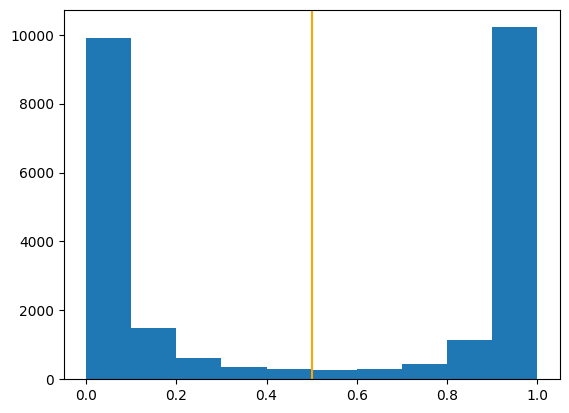

In [17]:
# roc auc score
pct_auc = roc_auc_score(y_valid, predictions)*100.0
print("ROC_AUC: {:0.2f}".format(pct_auc))

# plot predictions
plt.hist(predictions)
_ = plt.axvline(x = 0.5, color = 'orange')

# compare y hat to y
float_y_hat = []
for y in predictions:
    float_y_hat.append(y[0])

ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns = ['y_hat', 'y'])
ydf.head(10)

##### False Positives

In [18]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
0,0.964741,0
3,0.990185,0
8,0.966091,0
19,0.953431,0
32,0.994612,0
33,0.946615,0
46,0.969511,0
48,0.934053,0
58,0.975180,0
59,0.981451,0


##### False Negatives

In [19]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
1,0.063532,1
2,0.091398,1
4,0.073493,1
5,0.053041,1
9,0.039510,1
14,0.093946,1
20,0.010407,1
23,0.009162,1
27,0.064018,1
30,0.043850,1
